<a href="https://colab.research.google.com/github/yashv04/AI-Powered-Player-Scouting-Model/blob/main/AI_Powered_Player_Scouting_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('max.colwidth', None)
pd.set_option('display.expand_frame_repr', False)

In [76]:
deliveries = pd.read_csv('deliveries_till_2024.csv')
matches = pd.read_csv('matches_till_2024.csv')

In [77]:
df = deliveries.merge(matches, left_on='match_id', right_on='id')
df.fillna(0, inplace=True)
df.head(1)

,match_id,inning,batting_team,bowling_team,over,ball,batter,bowler,non_striker,batsman_runs,extra_runs,total_runs,extras_type,is_wicket,player_dismissed,dismissal_kind,fielder,id,season,city,date,match_type,player_of_match,venue,team1,team2,toss_winner,toss_decision,winner,result,result_margin,target_runs,target_overs,super_over,method,umpire1,umpire2
0,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,1,SC Ganguly,P Kumar,BB McCullum,0,1,1,legbyes,0,0,0,0,335982,2007/08,Bangalore,18-04-2008,League,BB McCullum,M Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,runs,140.0,223.0,20.0,N,0,Asad Rauf,RE Koertzen


In [78]:
# Function to classify each over into a game phase
def get_phase(over):
    if 0 <= over <= 6:
        return 'Powerplay'
    elif 7 <= over <= 15:
        return 'Middle'
    elif 16 <= over <= 20:
        return 'Death'
    else:
        return 'Unknown'  # fallback

# Apply the function to create a new 'phase' column
df['phase'] = df['over'].apply(get_phase)

In [79]:
# Group by batter and phase to calculate aggregated stats
batter_stats = df.groupby(['batter', 'phase']).agg(
    runs=('batsman_runs', 'sum'),
    balls_faced=('ball', 'count'),
    dismissals=('is_wicket', 'sum'),
    ones=('batsman_runs', lambda x: (x == 1).sum()),
    twos=('batsman_runs', lambda x: (x == 2).sum()),
    threes=('batsman_runs', lambda x: (x == 3).sum()),
    fours=('batsman_runs', lambda x: (x == 4).sum()),
    sixes=('batsman_runs', lambda x: (x == 6).sum())
).reset_index()

In [80]:
# Calculate strike rate for each batter in each phase
batter_stats['strike_rate'] = (batter_stats['runs'] / batter_stats['balls_faced']) * 100
batter_stats.head(3)

,batter,phase,runs,balls_faced,dismissals,ones,twos,threes,fours,sixes,strike_rate
0,A Ashish Reddy,Death,192,129,11,59,13,1,11,10,148.837209
1,A Ashish Reddy,Middle,83,60,3,23,7,0,4,5,138.333333
2,A Ashish Reddy,Powerplay,5,7,1,1,0,0,1,0,71.428571


 Pivot the Phase-Wise Table

In [81]:
# Pivot the table to get one row per batter with separate columns per phase
pivoted = batter_stats.pivot(index='batter', columns='phase', values=[
    'runs', 'balls_faced', 'dismissals', 'fours', 'sixes', 'strike_rate'
])

# Flatten multi-index columns (e.g., ('runs', 'Powerplay') -> 'runs_Powerplay')
pivoted.columns = ['{}_{}'.format(metric, phase) for metric, phase in pivoted.columns]
pivoted = pivoted.reset_index()
pivoted.fillna(0, inplace=True)

Normalize All Stats (0 to 1 Range)

In [82]:
from sklearn.preprocessing import MinMaxScaler

# Exclude the 'batter' column from scaling
features = pivoted.drop(columns=['batter'])
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

# Create normalized DataFrame
normalized_df = pd.DataFrame(scaled_features, columns=features.columns)
normalized_df['batter'] = pivoted['batter']  # Add batter name back

# Reorder columns: batter first
normalized_df = normalized_df[['batter'] + [col for col in normalized_df.columns if col != 'batter']]
normalized_df.head(1)

,batter,runs_Death,runs_Middle,runs_Powerplay,balls_faced_Death,balls_faced_Middle,balls_faced_Powerplay,dismissals_Death,dismissals_Middle,dismissals_Powerplay,fours_Death,fours_Middle,fours_Powerplay,sixes_Death,sixes_Middle,sixes_Powerplay,strike_rate_Death,strike_rate_Middle,strike_rate_Powerplay
0,A Ashish Reddy,0.068916,0.02221,0.001324,0.082905,0.020478,0.002184,0.120879,0.029126,0.009174,0.052133,0.015385,0.002058,0.057143,0.031847,0.0,0.496124,0.384259,0.298434


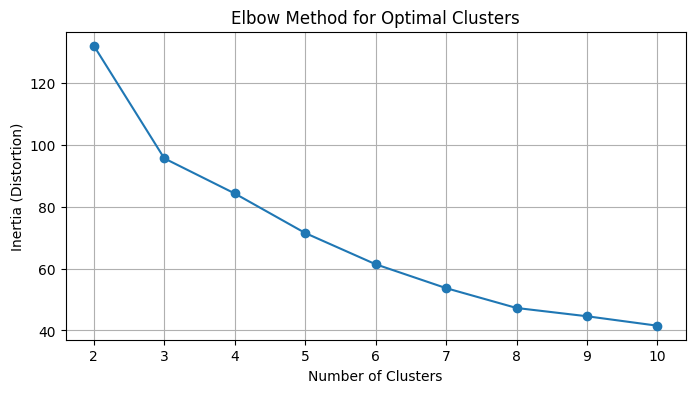

In [83]:
# Extract Only Features
# Remove the batter name for clustering
X = normalized_df.drop(columns=['batter'])
#Determine Optimal Number of Clusters (Elbow Method)
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Try K from 2 to 10
inertia = []
K_range = range(2, 11)

for k in K_range:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(X)
    inertia.append(model.inertia_)

# Plot elbow curve
plt.figure(figsize=(8, 4))
plt.plot(K_range, inertia, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia (Distortion)')
plt.grid(True)
plt.show()

In [84]:
#Apply K-Means Clustering (use k=4 for now)
# Fit final model
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X)

# Add clusters back to DataFrame
normalized_df['cluster'] = clusters

In [85]:
#Analyze Player Clusters
# Check sample players from each cluster
for c in sorted(normalized_df['cluster'].unique()):
    print(f"\n🧠 Cluster {c} — Sample Players:")
    print(normalized_df[normalized_df['cluster'] == c]['batter'].head(5).to_string(index=False))


🧠 Cluster 0 — Sample Players:
A Ashish Reddy
      A Badoni
    A Flintoff
     A Manohar
      A Mishra

🧠 Cluster 1 — Sample Players:
 A Chandila
   A Chopra
A Choudhary
A Dananjaya
   A Kamboj

🧠 Cluster 2 — Sample Players:
AB de Villiers
    AD Russell
      AR Patel
     AT Rayudu
     DA Miller

🧠 Cluster 3 — Sample Players:
AC Gilchrist
    AJ Finch
   AM Rahane
 BB McCullum
    CH Gayle


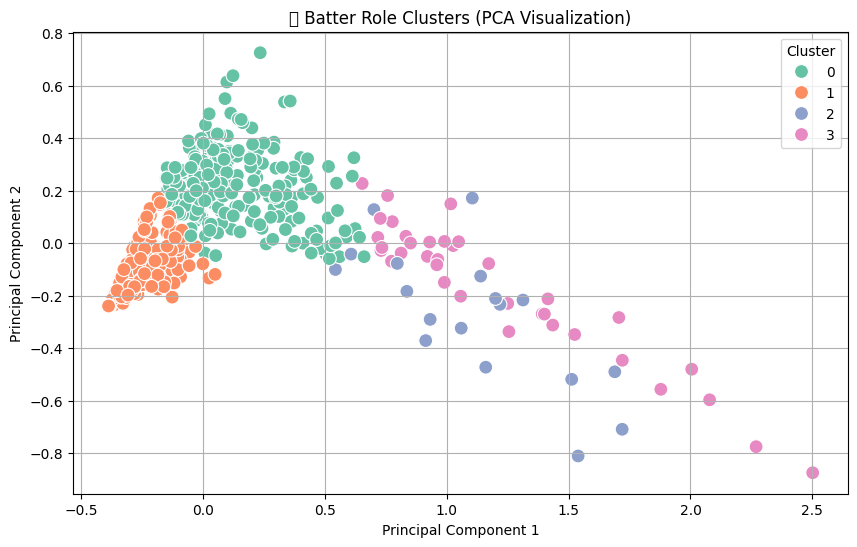

In [86]:
from sklearn.decomposition import PCA
import seaborn as sns

# Apply PCA to reduce dimensions to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Create DataFrame for plotting
viz_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
viz_df['cluster'] = clusters
viz_df['batter'] = normalized_df['batter']

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=viz_df, x='PC1', y='PC2', hue='cluster', palette='Set2', s=100)
plt.title("📊 Batter Role Clusters (PCA Visualization)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()

Analyze Cluster-Level Averages

In [87]:
# Get cluster-level averages
cluster_summary = normalized_df.groupby('cluster').mean(numeric_only=True)

# Transpose for better view
cluster_summary.T

cluster,0,1,2,3
runs_Death,0.044593,0.010196,0.366555,0.116336
runs_Middle,0.061639,0.003422,0.471115,0.403287
runs_Powerplay,0.040625,0.000596,0.104284,0.480734
balls_faced_Death,0.051677,0.016215,0.378570,0.120216
balls_faced_Middle,0.065725,0.004936,0.473872,0.389088
balls_faced_Powerplay,0.042104,0.001013,0.109014,0.472604
dismissals_Death,0.075855,0.030663,0.464591,0.167277
dismissals_Middle,0.087064,0.009657,0.525351,0.467098
dismissals_Powerplay,0.052037,0.001924,0.104485,0.490061
fours_Death,0.045782,0.009925,0.374934,0.124934


In [88]:
# Optional: Add manual cluster labels based on observations
cluster_labels = {
    0: "Death Overs Finisher",
    1: "Middle Overs Accumulator",
    2: "Powerplay Anchor",
    3: "All-phase Impact Batter"
}

normalized_df['role'] = normalized_df['cluster'].map(cluster_labels)

In [89]:
# Select top 3 players from each cluster based on overall normalized performance
top_picks = normalized_df.copy()
top_picks['overall_score'] = top_picks.drop(columns=['batter', 'cluster', 'role']).sum(axis=1)

# Get top 3 from each role
top_scouted_players = top_picks.groupby('role').apply(lambda x: x.nlargest(3, 'overall_score')).reset_index(drop=True)

# Display
top_scouted_players[['batter', 'role', 'overall_score']]

,batter,role,overall_score
0,V Kohli,All-phase Impact Batter,11.863627
1,RG Sharma,All-phase Impact Batter,11.120265
2,S Dhawan,All-phase Impact Batter,10.000433
3,MP Stoinis,Death Overs Finisher,4.298670
4,KS Williamson,Death Overs Finisher,4.146908
5,SP Narine,Death Overs Finisher,4.033126
6,Rashid Khan,Middle Overs Accumulator,2.086744
7,TH David,Middle Overs Accumulator,2.063057
8,R Powell,Middle Overs Accumulator,1.648644
9,MS Dhoni,Powerplay Anchor,9.271450


In [90]:
# Flag potential 'under-the-radar' if player isn't widely known or hyped
top_scouted_players['scouting_status'] = top_scouted_players['batter'].apply(
    lambda x: 'Undervalued Gem ' if x in ['Shashank Singh', 'TK Varma', 'Nehal Wadhera'] else 'Popular'
)

In [91]:
top_scouted_players.to_csv("scouting_report.csv", index=False)

 Debugging, Feature Tuning & Accuracy Boosting

In [92]:
# Calculate total balls faced
normalized_df['total_balls'] = normalized_df.filter(like='balls_faced').sum(axis=1)
# Filter players with at least 50 balls faced
filtered_df = normalized_df[normalized_df['total_balls'] >= 0.5].drop(columns=['total_balls'])

In [93]:
filtered_df.head(1)

,batter,runs_Death,runs_Middle,runs_Powerplay,balls_faced_Death,balls_faced_Middle,balls_faced_Powerplay,dismissals_Death,dismissals_Middle,dismissals_Powerplay,fours_Death,fours_Middle,fours_Powerplay,sixes_Death,sixes_Middle,sixes_Powerplay,strike_rate_Death,strike_rate_Middle,strike_rate_Powerplay,cluster,role
30,AB de Villiers,0.51005,0.751405,0.252119,0.408098,0.693515,0.25585,0.384615,0.601942,0.256881,0.50237,0.734615,0.240741,0.64,0.764331,0.125749,0.745932,0.383858,0.485065,2,Powerplay Anchor


In [94]:
# Add Advanced Features
# Example: Add boundary rate per phase (using original pivoted DataFrame)
for phase in ['Powerplay', 'Middle', 'Death']:
    runs_col = f"runs_{phase}"
    balls_col = f"balls_faced_{phase}"
    fours_col = f"fours_{phase}"
    sixes_col = f"sixes_{phase}"

    pivoted[f'boundary_pct_{phase}'] = (
        (pivoted[fours_col] + pivoted[sixes_col]) / pivoted[balls_col].replace(0, 1)
    )

In [95]:
# Alternative Clustering Algorithms
from sklearn.cluster import AgglomerativeClustering

# Fit Agglomerative Clustering on the FILTERED data
agg_model = AgglomerativeClustering(n_clusters=4)

filtered_data = filtered_df.drop(columns=['batter', 'role'])
agg_clusters = agg_model.fit_predict(filtered_data)

# Add clusters to the filtered DataFrame
filtered_df['agglo_cluster'] = agg_clusters

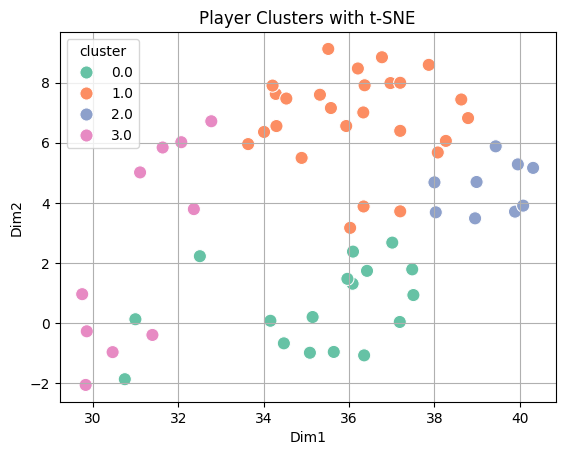

In [96]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_proj = tsne.fit_transform(X)

viz_df = pd.DataFrame(tsne_proj, columns=['Dim1', 'Dim2'])
viz_df['cluster'] = filtered_df['agglo_cluster']

sns.scatterplot(data=viz_df, x='Dim1', y='Dim2', hue='cluster', palette='Set2', s=90)
plt.title("Player Clusters with t-SNE")
plt.grid(True)
plt.show()

In [97]:
# Print cluster for key known players
for player in ['SA Yadav', 'MS Dhoni', 'V Kohli', 'AB de Villiers']:
    row = filtered_df[filtered_df['batter'] == player]
    if not row.empty:
        print(f"{player} → Cluster: {int(row['agglo_cluster'])}")


SA Yadav → Cluster: 0
MS Dhoni → Cluster: 0
V Kohli → Cluster: 2
AB de Villiers → Cluster: 0


Tableau Dashboard

In [98]:
# Export columns you want to visualize in Tableau
tableau_export = filtered_df.copy()

# Optional: Round for readability
numeric_cols = tableau_export.select_dtypes(include='number').columns
tableau_export[numeric_cols] = tableau_export[numeric_cols].round(2)

# Save to CSV
tableau_export.to_csv("tableau_scouting_dashboard_data.csv", index=False)

Define Radar Chart Function

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_batter_radar(player_name, df):
    """
    Plots a radar chart visualizing a batter's performance across different phases.

    Args:
        player_name (str): The name of the batter.
        df (pd.DataFrame): The DataFrame containing batter statistics.
    """

    # Filter player row
    player = df[df['batter'] == player_name].squeeze()


    labels = [
        'strike_rate_Powerplay', 'strike_rate_Middle', 'strike_rate_Death',
        'boundary_pct_Powerplay', 'boundary_pct_Middle', 'boundary_pct_Death'
    ]

    # Use .loc to access values by column names
    values = [player.loc[label] for label in labels]

    angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
    values += values[:1]  # Close the circle
    angles += angles[:1]

    label_display = [
        'SR Powerplay', 'SR Middle', 'SR Death',
        'Boundary% PP', 'Boundary% Mid', 'Boundary% Death'
    ]

    fig, ax = plt.subplots(figsize=(8, 6), subplot_kw=dict(polar=True))

    ax.plot(angles, values, color='crimson', linewidth=2)
    ax.fill(angles, values, color='crimson', alpha=0.25)

    ax.set_title(f"Radar Profile — {player_name}", fontsize=15)
    ax.set_thetagrids(np.degrees(angles[:-1]), label_display)
    ax.grid(True)

    plt.show()

In [100]:
# Add Advanced Features to filtered_df
# Example: Add boundary rate per phase (using original pivoted DataFrame)
for phase in ['Powerplay', 'Middle', 'Death']:
    runs_col = f"runs_{phase}"
    balls_col = f"balls_faced_{phase}"
    fours_col = f"fours_{phase}"
    sixes_col = f"sixes_{phase}"

    #Calculate and add boundary percentage to filtered_df
    filtered_df[f'boundary_pct_{phase}'] = (
        (filtered_df[fours_col] + filtered_df[sixes_col]) / filtered_df[balls_col].replace(0, 1)
    )

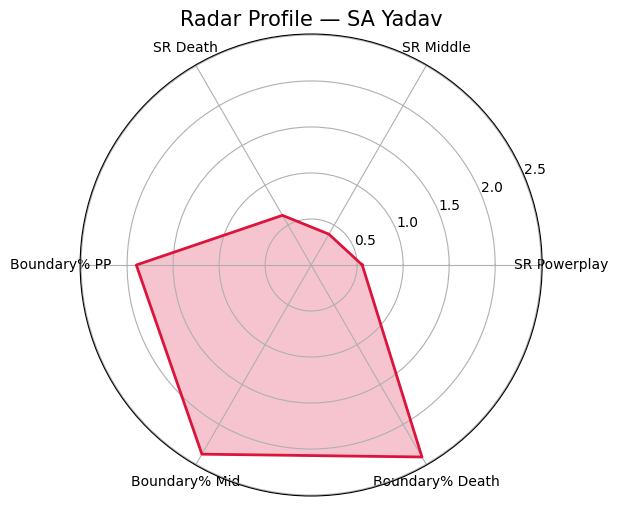

In [101]:
plot_batter_radar("SA Yadav", filtered_df)

In [102]:
#Head-to-Head Comparison
def compare_two_batters(player1, player2, df):
    labels = [
        'strike_rate_Powerplay', 'strike_rate_Middle', 'strike_rate_Death',
        'boundary_pct_Powerplay', 'boundary_pct_Middle', 'boundary_pct_Death'
    ]

    p1 = df[df['batter'] == player1].squeeze()
    p2 = df[df['batter'] == player2].squeeze()

    values1 = [p1[label] for label in labels] + [p1[labels[0]]]
    values2 = [p2[label] for label in labels] + [p2[labels[0]]]

    angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
    angles += angles[:1]

    label_display = [
        'SR Powerplay', 'SR Middle', 'SR Death',
        'Boundary% PP', 'Boundary% Mid', 'Boundary% Death'
    ]

    fig, ax = plt.subplots(figsize=(8, 6), subplot_kw=dict(polar=True))

    ax.plot(angles, values1, label=player1, color='darkblue')
    ax.fill(angles, values1, alpha=0.1, color='darkblue')

    ax.plot(angles, values2, label=player2, color='orangered')
    ax.fill(angles, values2, alpha=0.1, color='orangered')

    ax.set_thetagrids(np.degrees(angles[:-1]), label_display)
    ax.set_title(f"{player1} vs {player2} — Radar Comparison", fontsize=14)
    ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
    ax.grid(True)

    plt.show()

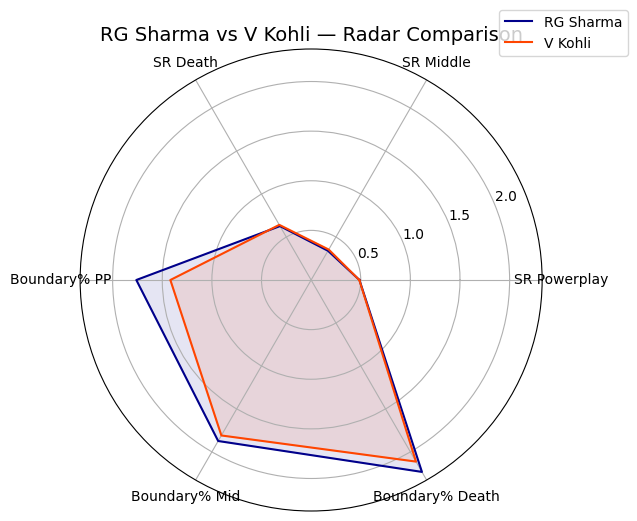

In [103]:
compare_two_batters("RG Sharma", "V Kohli", filtered_df)

Team Combination Builder

In [104]:
# You can manually or statistically map clusters
cluster_role_map = {
    0: "Powerplay Specialist",
    1: "Middle Overs Anchor",
    2: "Death Overs Finisher",
    3: "All-phase Versatile"
}

filtered_df['role_type'] = filtered_df['agglo_cluster'].map(cluster_role_map)

In [105]:
 #Create a Team Selection Function
 def build_best_xi(df, match_needs, top_n=2):
    """
    match_needs: dictionary with role weights. E.g.,
    {
        "Powerplay Specialist": 2,
        "Middle Overs Anchor": 3,
        "Death Overs Finisher": 3,
        "All-phase Versatile": 3
    }
    top_n: number of top players to pick from each role
    """
    selected_players = []

    for role, count in match_needs.items():
        top_players = (
            df[df['role_type'] == role]
            .sort_values('overall_score', ascending=False)
            .head(count)
        )
        selected_players.append(top_players)

    final_team = pd.concat(selected_players).reset_index(drop=True)
    return final_team

In [106]:
filtered_df['overall_score'] = filtered_df.drop(columns=['batter', 'cluster', 'role','role_type','agglo_cluster']).sum(axis=1)
match_strategy = {
    "Powerplay Specialist": 1,
    "Middle Overs Anchor": 2,
    "Death Overs Finisher": 4,
    "All-phase Versatile": 4
}

best_xi = build_best_xi(filtered_df, match_strategy)
best_xi[['batter', 'role_type', 'overall_score']]

,batter,role_type,overall_score
0,AD Russell,Powerplay Specialist,16.041228
1,V Sehwag,Middle Overs Anchor,14.305832
2,F du Plessis,Middle Overs Anchor,13.124216
3,V Kohli,Death Overs Finisher,17.203920
4,RG Sharma,Death Overs Finisher,16.988008
5,CH Gayle,Death Overs Finisher,16.858421
6,DA Warner,Death Overs Finisher,15.620350
7,MP Stoinis,All-phase Versatile,9.873645
8,MEK Hussey,All-phase Versatile,9.225490
9,KS Williamson,All-phase Versatile,8.765871


In [107]:
#Spinning Track – Need Rotators:
spin_track_strategy = {
    "Powerplay Specialist": 2,
    "Middle Overs Anchor": 4,
    "Death Overs Finisher": 2,
    "All-phase Versatile": 3
}
best_xi = build_best_xi(filtered_df, match_strategy)
best_xi[['batter', 'role_type', 'overall_score']]

,batter,role_type,overall_score
0,AD Russell,Powerplay Specialist,16.041228
1,V Sehwag,Middle Overs Anchor,14.305832
2,F du Plessis,Middle Overs Anchor,13.124216
3,V Kohli,Death Overs Finisher,17.203920
4,RG Sharma,Death Overs Finisher,16.988008
5,CH Gayle,Death Overs Finisher,16.858421
6,DA Warner,Death Overs Finisher,15.620350
7,MP Stoinis,All-phase Versatile,9.873645
8,MEK Hussey,All-phase Versatile,9.225490
9,KS Williamson,All-phase Versatile,8.765871


In [108]:
best_xi.to_csv("best_xi_team_strategy.csv", index=False)

In [109]:
#Final XI Selection Using Fixed Data
#Match Strategy (Weighted Preferences)
match_strategy = {
    "Powerplay Specialist": 2,
    "Middle Overs Anchor": 3,
    "Death Overs Finisher": 4,
    "All-phase Versatile": 2
}
def build_best_xi_with_fallback(df, role_weights, total_players=11):
    role_avail = df['role_type'].value_counts().to_dict()

    valid_roles = {role: weight for role, weight in role_weights.items() if role in role_avail}

    if not valid_roles:
        print("No valid roles available!")
        return pd.DataFrame()

    total_weight = sum(valid_roles.values())
    raw_counts = {
        role: round((weight / total_weight) * total_players)
        for role, weight in valid_roles.items()
    }

    count_diff = total_players - sum(raw_counts.values())
    if count_diff != 0:
        top_role = max(valid_roles, key=valid_roles.get)
        raw_counts[top_role] += count_diff

    selected_players = []
    for role, count in raw_counts.items():
        role_df = df[df['role_type'] == role]
        if role_df.empty:
            print(f"Skipping role: {role}")
            continue
        top_players = role_df.sort_values('overall_score', ascending=False).head(count)
        selected_players.append(top_players)

    final_team = pd.concat(selected_players).reset_index(drop=True)
    return final_team

In [110]:
final_xi = build_best_xi_with_fallback(filtered_df, match_strategy)
print(f"Final XI: {len(final_xi)} players")
final_xi[['batter', 'role_type', 'overall_score']]

Final XI: 11 players


,batter,role_type,overall_score
0,AD Russell,Powerplay Specialist,16.041228
1,AB de Villiers,Powerplay Specialist,15.130202
2,V Sehwag,Middle Overs Anchor,14.305832
3,F du Plessis,Middle Overs Anchor,13.124216
4,JC Buttler,Middle Overs Anchor,13.106617
5,V Kohli,Death Overs Finisher,17.203920
6,RG Sharma,Death Overs Finisher,16.988008
7,CH Gayle,Death Overs Finisher,16.858421
8,DA Warner,Death Overs Finisher,15.620350
9,MP Stoinis,All-phase Versatile,9.873645


In [111]:
final_xi.to_csv("match_specific_xi.csv", index=False)

Phase-wise Match Simulation

In [112]:
final_xi[['batter', 'role_type', 'strike_rate_Powerplay', 'boundary_pct_Powerplay',
          'strike_rate_Middle', 'boundary_pct_Middle',
          'strike_rate_Death', 'boundary_pct_Death']]

,batter,role_type,strike_rate_Powerplay,boundary_pct_Powerplay,strike_rate_Middle,boundary_pct_Middle,strike_rate_Death,boundary_pct_Death
0,AD Russell,Powerplay Specialist,0.899895,3.989900,0.413191,3.349301,0.622807,2.459836
1,AB de Villiers,Powerplay Specialist,0.485065,1.432437,0.383858,2.161375,0.745932,2.799255
2,V Sehwag,Middle Overs Anchor,0.580832,2.076182,0.473367,3.456795,0.733333,3.253167
3,F du Plessis,Middle Overs Anchor,0.548635,1.894897,0.351682,1.638445,0.630303,2.236840
4,JC Buttler,Middle Overs Anchor,0.553846,2.071750,0.405515,2.495109,0.613095,2.164915
5,V Kohli,Death Overs Finisher,0.485482,1.418425,0.354285,1.808917,0.641565,2.112951
6,RG Sharma,Death Overs Finisher,0.486711,1.761353,0.339844,1.873402,0.627200,2.232987
7,CH Gayle,Death Overs Finisher,0.539812,2.446248,0.430533,3.275517,0.644338,2.441670
8,DA Warner,Death Overs Finisher,0.545318,1.858466,0.383015,2.105293,0.581232,1.924605
9,MP Stoinis,All-phase Versatile,0.484765,1.547029,0.360581,2.142289,0.554066,1.885657


In [113]:
# Merge phase-wise stats back to selected XI
phase_stats_cols = [
    'batter',
    'strike_rate_Powerplay', 'boundary_pct_Powerplay',
    'strike_rate_Middle', 'boundary_pct_Middle',
    'strike_rate_Death', 'boundary_pct_Death'
]

final_xi_phase = final_xi.merge(
    filtered_df[phase_stats_cols],
    on='batter',
    how='left',
    suffixes=('', '_y')
)
final_xi_phase = final_xi_phase[[c for c in final_xi_phase.columns if not c.endswith('_y') or c.startswith('batter')]]
print(final_xi_phase.columns)

pp_batters = final_xi_phase.sort_values('strike_rate_Powerplay', ascending=False).head(2)
mid_batters = final_xi_phase.sort_values('strike_rate_Middle', ascending=False).head(2)
death_batters = final_xi_phase.sort_values('strike_rate_Death', ascending=False).head(2)

Index(['batter', 'runs_Death', 'runs_Middle', 'runs_Powerplay',
       'balls_faced_Death', 'balls_faced_Middle', 'balls_faced_Powerplay',
       'dismissals_Death', 'dismissals_Middle', 'dismissals_Powerplay',
       'fours_Death', 'fours_Middle', 'fours_Powerplay', 'sixes_Death',
       'sixes_Middle', 'sixes_Powerplay', 'strike_rate_Death',
       'strike_rate_Middle', 'strike_rate_Powerplay', 'cluster', 'role',
       'agglo_cluster', 'boundary_pct_Powerplay', 'boundary_pct_Middle',
       'boundary_pct_Death', 'role_type', 'overall_score'],
      dtype='object')


In [114]:
# --- Phase Simulation Function ---

def simulate_phase_realistic(df, sr_column, overs, batters_per_phase=5, min_sr=110):
    balls = overs * 6
    df = df.copy()

    # Normalized SRs converted to real strike rates (e.g., 0.5 -> 125)
    df['adjusted_sr'] = df[sr_column].fillna(0.5).apply(lambda x: max(x * 250, min_sr))

    # Pick top batters
    top_batters = df.sort_values('adjusted_sr', ascending=False).head(batters_per_phase)

    balls_per_batter = balls // batters_per_phase
    phase_runs = ((top_batters['adjusted_sr'] / 100) * balls_per_batter).sum()

    return round(phase_runs, 1)

In [115]:
# Simulate each phase
powerplay_runs = simulate_phase_realistic(final_xi_phase, 'strike_rate_Powerplay', overs=6)
middle_runs = simulate_phase_realistic(final_xi_phase, 'strike_rate_Middle', overs=9)
death_runs = simulate_phase_realistic(final_xi_phase, 'strike_rate_Death', overs=5)

# Total score
total_runs = powerplay_runs + middle_runs + death_runs

# Output
print(f"Powerplay Runs: {powerplay_runs:.1f}")
print(f" Middle Overs Runs: {middle_runs:.1f}")
print(f" Death Overs Runs: {death_runs:.1f}")
print(f"\n Total Simulated Team Score: {total_runs:.1f}")

Powerplay Runs: 54.7
 Middle Overs Runs: 55.8
 Death Overs Runs: 50.9

 Total Simulated Team Score: 161.4


The Colab employs a K-Means clustering model, trained on normalized batter statistics across different game phases (Powerplay, Middle, Death). This model segments batters into distinct roles based on their performance patterns. An elbow method determines the optimal cluster count. Further analysis, including PCA visualization, helps interpret and label these clusters. Agglomerative clustering and t-SNE are explored as alternatives. The model facilitates data-driven team selection, strategic decision-making, and unearthing undervalued players, leveraging machine learning for deeper cricketing insights.

The analysis reveals that using K-Means clustering on batter statistics effectively identifies distinct player roles in cricket. These roles can be leveraged to create data-driven team combinations tailored to specific match situations and strategies. The Colab demonstrates this through visualizations, simulations, and the creation of optimal team lineups for different scenarios. It also highlights the potential to uncover undervalued players based on their cluster assignments and overall performance scores. Overall, the analysis provides a valuable framework for data-driven decision-making in cricket, potentially leading to more strategic team building and scouting.